In [12]:
from models import vae_HYP, vae_EUCL
import geoopt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from hypmath import poincareball
import pandas as pd 
from tqdm import tqdm
import time

In [13]:
transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,))
        ])

trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET',
                              download=True, train=True, transform=transform)
testset = datasets.MNIST('PATH_TO_STORE_TESTSET',
                            download=True, train=False, transform=transform)

size = len(trainset)
#print(size)

#Splitting training set into training and validation data
train_data, val_data = torch.utils.data.random_split(trainset, [int(size-size*0.2), int(size*0.2)])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True, num_workers=6, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=256, num_workers=6, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True, num_workers=6, pin_memory=True)


60000


In [14]:
model = vae_EUCL.VariationalAutoencoder(latent_dims=4)

In [15]:
learning_rate = 1e-3

In [16]:
#optim = geoopt.optim.RiemannianAdam(model.parameters(), lr=learning_rate)
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
### Training function
def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        # x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        #ball = poincareball.PoincareBall()
        loss = ((x - x_hat)**2).sum() + (vae.encoder.kl)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [18]:
### Testing function
def test_epoch(vae, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            # x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [19]:
def plot_ae_outputs(encoder,decoder,n):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = testset[i][0].unsqueeze(0)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 45825.640625
	 partial train loss (single batch): 44599.472656
	 partial train loss (single batch): 43473.035156
	 partial train loss (single batch): 42589.695312
	 partial train loss (single batch): 41852.171875
	 partial train loss (single batch): 41058.722656
	 partial train loss (single batch): 40585.363281
	 partial train loss (single batch): 39968.578125
	 partial train loss (single batch): 39359.425781
	 partial train loss (single batch): 38725.136719
	 partial train loss (single batch): 38286.093750
	 partial train loss (single batch): 37764.281250
	 partial train loss (single batch): 37359.160156
	 partial train loss (single batch): 36833.539062
	 partial train loss (single batch): 36384.222656
	 partial train loss (single batch): 35953.062500
	 partial train loss (single batch): 35430.378906
	 partial train loss (single batch): 35080.925781
	 partial train loss (single batch): 34652.316406
	 partial train loss (single batch): 34284.261719


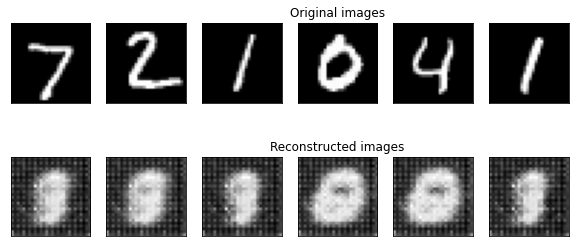

	 partial train loss (single batch): 15380.637695
	 partial train loss (single batch): 15238.572266
	 partial train loss (single batch): 15259.596680
	 partial train loss (single batch): 15749.000000
	 partial train loss (single batch): 15151.606445
	 partial train loss (single batch): 15317.053711
	 partial train loss (single batch): 15237.311523
	 partial train loss (single batch): 15090.804688
	 partial train loss (single batch): 15050.369141
	 partial train loss (single batch): 15001.711914
	 partial train loss (single batch): 15297.992188
	 partial train loss (single batch): 14749.900391
	 partial train loss (single batch): 14994.525391
	 partial train loss (single batch): 15115.881836
	 partial train loss (single batch): 14943.014648
	 partial train loss (single batch): 14836.916016
	 partial train loss (single batch): 14584.486328
	 partial train loss (single batch): 15184.541992
	 partial train loss (single batch): 14972.974609
	 partial train loss (single batch): 14761.018555


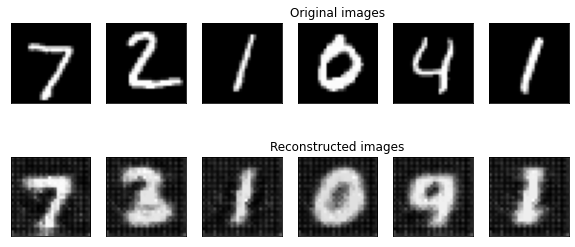

	 partial train loss (single batch): 12760.281250
	 partial train loss (single batch): 12434.610352
	 partial train loss (single batch): 12230.996094
	 partial train loss (single batch): 12239.026367
	 partial train loss (single batch): 12206.634766
	 partial train loss (single batch): 12130.683594
	 partial train loss (single batch): 12344.237305
	 partial train loss (single batch): 12483.406250
	 partial train loss (single batch): 12100.748047
	 partial train loss (single batch): 12425.784180
	 partial train loss (single batch): 12378.301758
	 partial train loss (single batch): 12186.833008
	 partial train loss (single batch): 12787.981445
	 partial train loss (single batch): 12252.294922
	 partial train loss (single batch): 12192.746094
	 partial train loss (single batch): 11965.906250
	 partial train loss (single batch): 12308.313477
	 partial train loss (single batch): 12399.055664
	 partial train loss (single batch): 12015.777344
	 partial train loss (single batch): 11891.891602


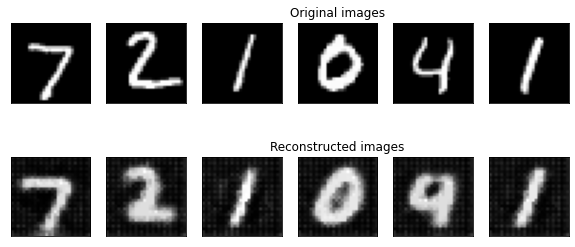

	 partial train loss (single batch): 11432.136719
	 partial train loss (single batch): 11433.456055
	 partial train loss (single batch): 11638.440430
	 partial train loss (single batch): 11208.900391
	 partial train loss (single batch): 11456.711914
	 partial train loss (single batch): 11470.673828
	 partial train loss (single batch): 11616.606445
	 partial train loss (single batch): 11408.520508
	 partial train loss (single batch): 11480.723633
	 partial train loss (single batch): 11614.988281
	 partial train loss (single batch): 11428.582031
	 partial train loss (single batch): 11564.463867
	 partial train loss (single batch): 11488.198242
	 partial train loss (single batch): 11322.557617
	 partial train loss (single batch): 11345.537109
	 partial train loss (single batch): 11144.663086
	 partial train loss (single batch): 11434.716797
	 partial train loss (single batch): 11598.858398
	 partial train loss (single batch): 11271.702148
	 partial train loss (single batch): 11391.380859


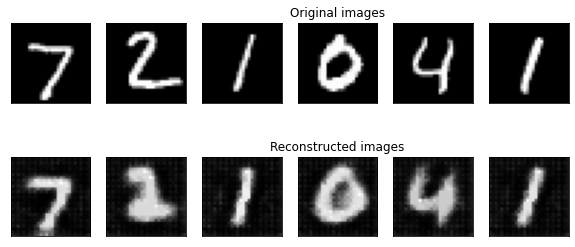

	 partial train loss (single batch): 11341.051758
	 partial train loss (single batch): 10837.178711
	 partial train loss (single batch): 11123.766602
	 partial train loss (single batch): 11551.411133
	 partial train loss (single batch): 11041.974609
	 partial train loss (single batch): 11202.665039
	 partial train loss (single batch): 10986.476562
	 partial train loss (single batch): 10879.188477
	 partial train loss (single batch): 11236.951172
	 partial train loss (single batch): 11037.317383
	 partial train loss (single batch): 11175.399414
	 partial train loss (single batch): 11129.163086
	 partial train loss (single batch): 10945.279297
	 partial train loss (single batch): 10862.688477
	 partial train loss (single batch): 10920.530273
	 partial train loss (single batch): 10898.435547
	 partial train loss (single batch): 11464.607422
	 partial train loss (single batch): 10953.283203
	 partial train loss (single batch): 10874.287109
	 partial train loss (single batch): 10898.184570


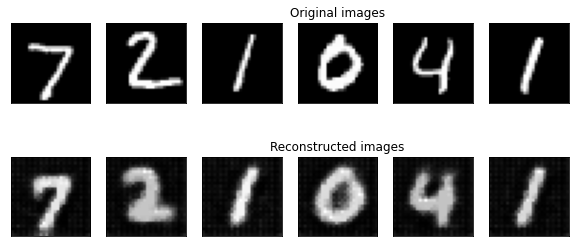

In [20]:
num_epochs = 5

for epoch in range(num_epochs):
   train_loss = train_epoch(model, trainloader,optim)
   val_loss = test_epoch(model, valloader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   plot_ae_outputs(model.encoder, model.decoder,n=6)




In [1]:
encoded_samples = []
for sample in tqdm(testset):
    img = sample[0].unsqueeze(0)
    label = sample[1]
    # Encode image
    model.eval()
    with torch.no_grad():
        encoded_img  = model.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

print(label)

NameError: name 'tqdm' is not defined

In [22]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()